# 01c — Labels from MRDS (positives per grid cell)

This notebook converts **MRDS** point records into **binary labels per grid cell**:
- `y=1` if any MRDS point intersects the grid cell  
- `y=0` otherwise

Options:
- Filter to **critical commodities** (Cu, Ni, Co, Li, etc.)
- Save final labels to `data/processed/y_labels.npy`


In [1]:
# 1) Imports & params
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import joblib
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path
import sys

# Make 'src/' importable (assumes this notebook lives in notebooks/)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.data_utils import bounding_box_for_state, state_polygon
from src.features import build_grid_from_bbox, grid_centroids

# ---- Config ----

STATE = "Missouri"                        # or "MO" depending on data_utils
MRDS_CSV = project_root / "data/raw/mrds.csv"            # your MRDS CSV with the headers you shared
FILTER_CRITICAL = True                    # False to use all MRDS
CRITICAL_COMMODITIES = {"CO","CU","NI","CO","LI"}  # tweak set as needed
GRID_PATH = project_root / "data/processed/grid_gdf.joblib"  # preferred if you already built the grid
SAVE_LABELS_PATH = project_root / "data/processed/y_labels.npy"
SAVE_FIGURES_PATH = project_root / "figures"

os.makedirs(GRID_PATH.parent, exist_ok=True)
os.makedirs(SAVE_LABELS_PATH.parent, exist_ok=True)
os.makedirs(SAVE_FIGURES_PATH, exist_ok=True)


In [2]:
## 2) Load / build grid (polygon-masked)

poly = state_polygon(STATE)  # uses data/raw/state_geology.gpkg if available; else falls back to bbox
if hasattr(poly, "geom_type"):
    # shapely Polygon/MultiPolygon; ensure CRS later matches 4326
    pass

if os.path.exists(GRID_PATH):
    grid = joblib.load(GRID_PATH)
    print(f"Loaded grid from {GRID_PATH} with {len(grid)} cells")

    # Ensure the loaded grid is masked to the polygon (older cache may be bbox-only)
    n_before = len(grid)
    grid = grid[grid.geometry.intersects(poly)].copy().reset_index(drop=True)
    if len(grid) != n_before:
        print(f"Masked cached grid to state polygon: {n_before} -> {len(grid)} cells")
        joblib.dump(grid, GRID_PATH)  # overwrite cached grid with masked version
else:
    print(f"Grid not found at {GRID_PATH}; building from state polygon for {STATE}")
    # Build on polygon bbox (fast), then mask to polygon (accurate)
    bbox = poly.bounds  # (minx, miny, maxx, maxy)
    grid = build_grid_from_bbox(bbox)
    grid = grid[grid.geometry.intersects(poly)].copy().reset_index(drop=True)
    joblib.dump(grid, GRID_PATH)
    print(f"Built and saved polygon-masked grid to {GRID_PATH} with {len(grid)} cells")

# Ensure lat/lon CRS for joins
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)


Loaded grid from c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\grid_gdf.joblib with 7646 cells


In [3]:
## 3) Load MRDS & (optional) commodity filter
mrds = pd.read_csv(MRDS_CSV)
print("MRDS rows (raw):", len(mrds))

# Drop missing coords
mrds = mrds.dropna(subset=["longitude","latitude"])
print("MRDS rows (with coords):", len(mrds))

# Keep reasonable lon/lat bounds
mrds = mrds[(mrds["longitude"].between(-180,180)) & (mrds["latitude"].between(-90,90))]
print("MRDS rows (sane coords):", len(mrds))

# Optional: filter to critical commodities
if FILTER_CRITICAL:
    def row_has_critical(row):
        vals = [str(row.get(c, "")).upper() for c in ("commod1","commod2","commod3")]
        joined = "|".join(vals)
        return any(com in joined for com in CRITICAL_COMMODITIES)
    mrds = mrds[mrds.apply(row_has_critical, axis=1)]
    print("MRDS rows (critical commodities):", len(mrds))

# Clip to state bbox (avoid out-of-state positives)
minx, miny, maxx, maxy = bounding_box_for_state(STATE)
mrds = mrds[
    mrds["longitude"].between(minx, maxx) &
    mrds["latitude"].between(miny, maxy)
]
print("MRDS rows (clipped to state bbox):", len(mrds))

C:\Users\angel\AppData\Local\Temp\ipykernel_48560\363331474.py:2: DtypeWarning: Columns (3,17,25,26,28,34,35,37,39,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  mrds = pd.read_csv(MRDS_CSV)


MRDS rows (raw): 304632
MRDS rows (with coords): 304613
MRDS rows (sane coords): 304613
MRDS rows (critical commodities): 127595
MRDS rows (clipped to state bbox): 1687


In [4]:
## 4) Create GeoDataFrame & spatial join to grid
# Create points GDF
occ = gpd.GeoDataFrame(
    mrds,
    geometry=gpd.points_from_xy(mrds["longitude"], mrds["latitude"]),
    crs="EPSG:4326",
)
occ = occ[occ.within(poly)].copy()
print("MRDS points inside state polygon:", len(occ))


# Spatial join — reset grid index so we can group back reliably
# NOTE: Requires rtree or pygeos installed for speed (conda-forge: rtree)
joined = gpd.sjoin(grid.reset_index(), occ[["geometry"]], how="left", predicate="intersects")

# Aggregate back to 1 row per grid cell:
# y=1 if any match exists for that cell; else 0
y_series = joined.groupby("index")["index_right"].apply(lambda x: int(x.notna().any()))

# Align with original grid index/order
grid = grid.copy()
grid["y_label"] = y_series.reindex(grid.index, fill_value=0).astype(int)

# Save labels
y = grid["y_label"].values.astype(np.int64)
np.save(SAVE_LABELS_PATH, y)
print(f"Saved labels to {SAVE_LABELS_PATH}")
print("Positive cells:", int(y.sum()), "of", len(y), "| Pos rate:", float(y.mean()))

MRDS points inside state polygon: 1088
Saved labels to c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\y_labels.npy
Positive cells: 666 of 7646 | Pos rate: 0.08710436829714883


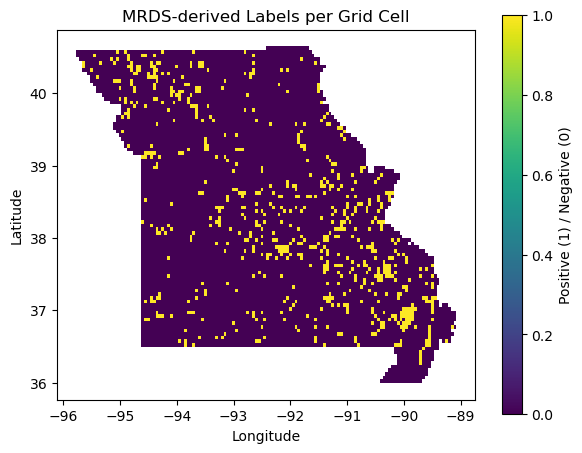

,n_cells,n_pos,pos_rate,filter_critical,critical_set
0,7646,666,0.087104,True,"CO,CU,LI,NI"


Saved c:\Users\angel\ore-exploration-ml\ore-exploration-ml\figures\labels_summary.png and c:\Users\angel\ore-exploration-ml\ore-exploration-ml\figures\labels_summary.csv


In [5]:
## 5) Quick visualization & summary
# 5a) Map (quick sanity)
fig, ax = plt.subplots(figsize=(6,6))
grid.assign(pos=grid["y_label"]).plot(
    column="pos", ax=ax, cmap="viridis", legend=True,
    legend_kwds={"label": "Positive (1) / Negative (0)", "shrink": 0.7}
)
ax.set_title("MRDS-derived Labels per Grid Cell")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout()
plt.savefig(SAVE_FIGURES_PATH / "labels_summary.png", dpi=180)
plt.show()

# 5b) Small table summary
summary = pd.DataFrame({
    "n_cells": [len(grid)],
    "n_pos": [int(y.sum())],
    "pos_rate": [float(y.mean())],
    "filter_critical": [FILTER_CRITICAL],
    "critical_set": [",".join(sorted(CRITICAL_COMMODITIES)) if FILTER_CRITICAL else ""],
})
display(summary)
summary.to_csv(SAVE_FIGURES_PATH / "labels_summary.csv", index=False)
print(f"Saved {SAVE_FIGURES_PATH / 'labels_summary.png'} and {SAVE_FIGURES_PATH / 'labels_summary.csv'}")

np.save(project_root / "data/processed/y_labels_crit.npy", y)
with open(project_root / "data/processed/labels_meta.txt","w") as f:
    f.write("source=MRDS\nfilter_critical=True\ncommodities=CU,NI,CO,LI\n")